# Import packages

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
from numpy import mean,std
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score,KFold,cross_validate,RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.classifier import EnsembleVoteClassifier
import joblib

# Load data and fitted models 

In [2]:
X_train = (pd.read_csv('data/X_train.csv',header=None,skiprows=1,index_col=0).values).tolist()
x_test = (pd.read_csv('data/x_test.csv',header=None,skiprows=1,index_col=0).values).tolist()

y_train = sum(((pd.read_csv('data/y_train.csv',header=None,skiprows=1,index_col=0).values).tolist()),[])
y_test = sum(((pd.read_csv('data/y_test.csv',header=None, skiprows=1,index_col=0).values).tolist()),[])

In [3]:
#standard normalization for KNN and Neural Network
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

X_train_sn = (X_train - mu)/sigma
x_test_sn = (x_test - mu)/sigma

In [4]:
dt_clf = joblib.load('saved_model/tree.pkl')
knn_clf = joblib.load('saved_model/knn.pkl')
nb_clf = joblib.load('saved_model/bayes.pkl')
nn_clf = joblib.load('saved_model/neural.pkl')

# Implement ensemble classifier

Parameters:
- clfs: A list of classifiers. Four base estimators in this task.
- weights: Sequence of weights to weight the occurrences of predicted class labels. Set above models to have the same weights.
- voting: If 'hard', uses predicted class labels for majority rule voting. Else if 'soft', predicts the class label based on the argmax of the sums of the predicted probalities.
- fit_base_estimators: Refits classifiers in clfs if True; if False, uses references to the clfs. fit_base_estimators=False allows use of classifiers were already fit, but it would raise a NotFitterError when performing cross-validating.


In [5]:
vot_clf = EnsembleVoteClassifier([dt_clf,knn_clf,nb_clf,nn_clf], weights=[1,1,1,1]
                                 ,voting = "soft"
                                 ,fit_base_estimators=False
                                )

Fit the voting classifier and measure the accuracy of voting classifier. 

In [6]:
vot_clf = vot_clf.fit(X_train,y_train)
vot_pred=vot_clf.predict(x_test)

/opt/anaconda3/lib/python3.8/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


In [7]:
accuracy = accuracy_score(y_test,vot_pred)
print("Ensemble model accuracy:",accuracy)

Ensemble model accuracy: 0.5384615384615384


Measure the train and test accuracy of each classifier, including the ensembled one.

In [8]:
dicct = {}
for clf in (knn_clf, nn_clf):
    print(clf.__class__.__name__)
    y_pred = clf.predict(X_train_sn)
    print('\ttrain:', accuracy_score(y_train, y_pred))
    y_pred = clf.predict(x_test_sn)
    print('\ttest:', accuracy_score(y_test, y_pred))
    dicct[clf.__class__.__name__] = accuracy_score(y_test, y_pred)

for clf in (dt_clf, nb_clf, vot_clf):
    print(clf.__class__.__name__)
    y_pred = clf.predict(X_train)
    print('\ttrain:', accuracy_score(y_train, y_pred))
    y_pred = clf.predict(x_test)
    print('\ttest:', accuracy_score(y_test, y_pred))
    dicct[clf.__class__.__name__] = accuracy_score(y_test, y_pred)

KNeighborsClassifier
	train: 0.967741935483871
	test: 0.46153846153846156
MLPClassifier
	train: 0.5870967741935483
	test: 0.23076923076923078
DecisionTreeClassifier
	train: 0.5419354838709678
	test: 0.41025641025641024
CategoricalNB
	train: 0.6709677419354839
	test: 0.5128205128205128
EnsembleVoteClassifier
	train: 0.7161290322580646
	test: 0.5384615384615384


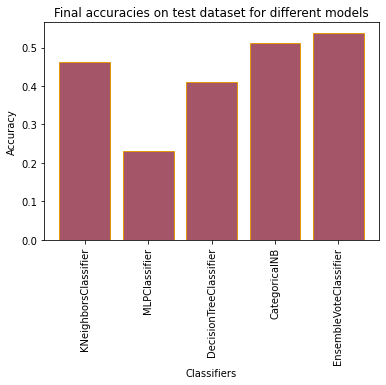

In [9]:
x = [i for i in dicct.keys()]
y = [i for i in dicct.values()]
plt.bar(x,y,color = '#A45568',edgecolor='#E3990E')
plt.xlabel('Classifiers')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Final accuracies on test dataset for different models')
plt.rcParams['figure.figsize'] = (8,10)

# Accuracy Evaluation

The confusion matrix provides a better visualisation of the model predictions versus the true values. Every row represents true values of instances and columns represent predicted values of them. The diagonal values of the confusion matrix are indicated to make the correct classification.

Text(56.760000000000005, 0.5, 'Predicted label')

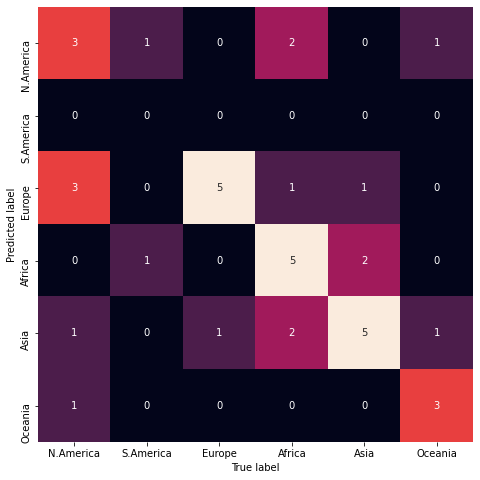

In [10]:
#confision matrix https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix_ensemble = confusion_matrix(y_test, vot_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix_ensemble.T, square=True, annot=True, fmt='d', cbar=False, ax=ax)
ax.yaxis.set_ticklabels(['N.America','S.America','Europe','Africa','Asia','Oceania'])
ax.xaxis.set_ticklabels(['N.America','S.America','Europe','Africa','Asia','Oceania'])
plt.xlabel('True label')
plt.ylabel('Predicted label')